In [1]:
import re
import numpy as np
import math
import tensorflow as tf

from matplotlib import pyplot as plt
%matplotlib inline
import sklearn.datasets
from sklearn import preprocessing, model_selection

In [2]:
import sys
sys.path.append('NPEET_LNC/')
from lnc import MI
entropy = lambda x: MI.entropy(x,k=3,base=np.exp(1),intens=1e-10)

# Data loading

In [3]:
# I use the code snippet from https://stackoverflow.com/questions/7368739/numpy-and-16-bit-pgm/7369986
# It read PGM image buffer string and return a numpy array
def read_pgm2(buffer, byteorder='>'):
    """Return image data from a raw PGM file as numpy array.
    Format specification: http://netpbm.sourceforge.net/doc/pgm.html
    """
    #with open(filename, 'rb') as f:
    #    buffer = f.read()
    try:
        header, width, height, maxval = re.search(
            b"(^P5\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    except AttributeError:
        raise ValueError("Not a raw PGM file: '%s'" % filename)
    #print 'width',width, 'height', height
    
    return np.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=15#len(header)
                            ).reshape((int(height), int(width)))

In [4]:
dataset0 = sklearn.datasets.load_files('data/CroppedYale', shuffle=True)

data/CroppedYale/yaleB36/yaleB36_P00A+070E-35.pgm
34
yaleB36
2432


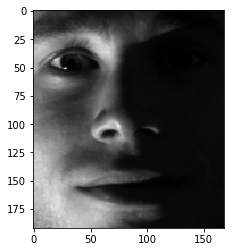

In [5]:
# Here is some sanity checks of the parsed dataset
idx0 = 10 #len(dataset0.filenames)-1
print(dataset0.filenames[idx0])
print(dataset0.target[idx0])
print(dataset0.target_names[dataset0.target[idx0]])
print(len(dataset0.filenames))
image0 = read_pgm2(dataset0.data[idx0])
plt.imshow(image0, plt.cm.gray)

In [6]:
# This cell includes the splittign of training and test set.
X = np.stack(map(read_pgm2, dataset0.data))
# X = X[:size0]

shapeX = X.shape
X = X.reshape((shapeX[0],shapeX[1]*shapeX[2]))
X = preprocessing.scale(X.astype(float),axis=1) # Mean removal and variance scaling

y = dataset0.target
enc = preprocessing.OneHotEncoder()
y = enc.fit_transform(y.reshape(-1, 1)).toarray()
# y = y.reshape(-1)
# y = y[:size0]

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.9, random_state=42)

In [7]:
X_train.shape

(243, 32256)

# Optimal Encoding

In [8]:
from networks import MLP
from OptimalEncoding import OptimalEncoding

Instructions for updating:
Use the retry module or similar alternatives.


## Autoencoding

In [9]:
n_in = X.shape[-1]
k = 2
n_out = X.shape[-1]

widths = [300, 300]

sigma = .1

In [10]:
encoder = MLP(n_in, k, widths)
decoder = MLP(k, n_out, widths)

In [11]:
oe = OptimalEncoding(encoder, decoder, k)

100%|██████████| 100/100 [00:08<00:00, 12.38it/s]


Sigma: 0.100000
Final task loss: -43531.308594


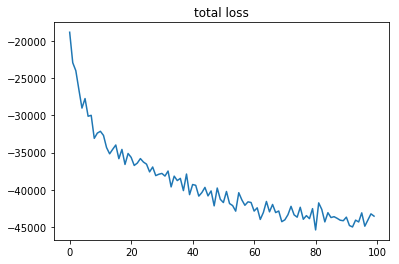

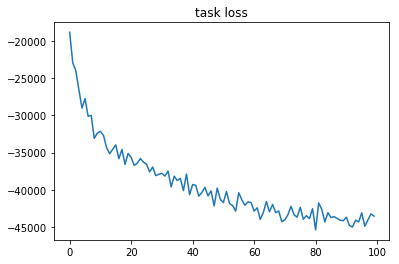

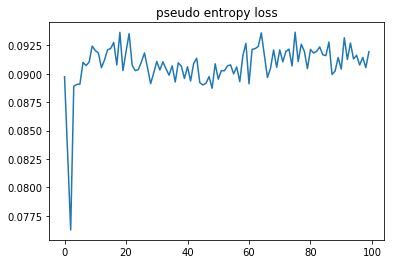

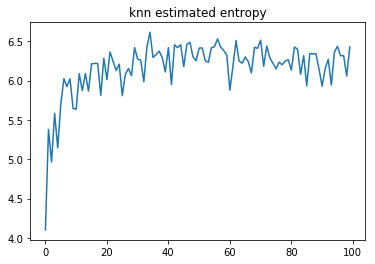

In [12]:
oe.train(X_train, y=None, 
         min_entropy=True, sigma = sigma, task = 'autoencoder', 
         heteroskedastic = True, n_samples = 5,
         epochs=100, batch_size=64, lr=1e-3)

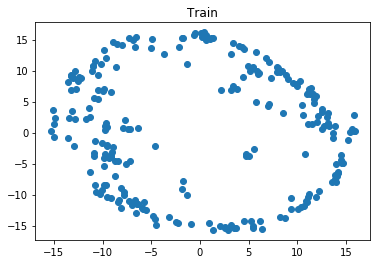

In [13]:
zhat_train = oe.encode(X_train, sigma=sigma)
plt.scatter(zhat_train[:,0], zhat_train[:,1])
plt.title('Train')

In [14]:
entropy(zhat_train)

5.8141447604054592

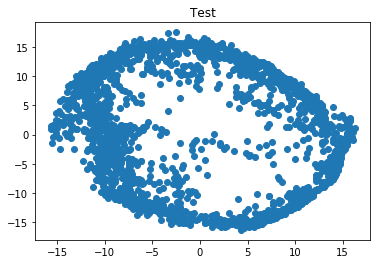

In [15]:
zhat_test = oe.encode(X_test, sigma=0)
plt.scatter(zhat_test[:,0], zhat_test[:,1])
plt.title('Test')

In [16]:
entropy(zhat_test)

5.7196100956893368

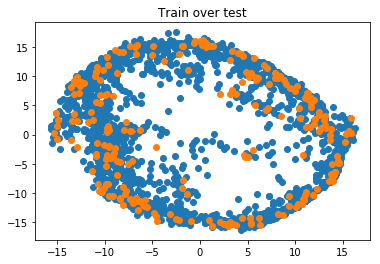

In [17]:
plt.scatter(zhat_test[:,0], zhat_test[:,1])
plt.scatter(zhat_train[:,0], zhat_train[:,1])
plt.title('Train over test')

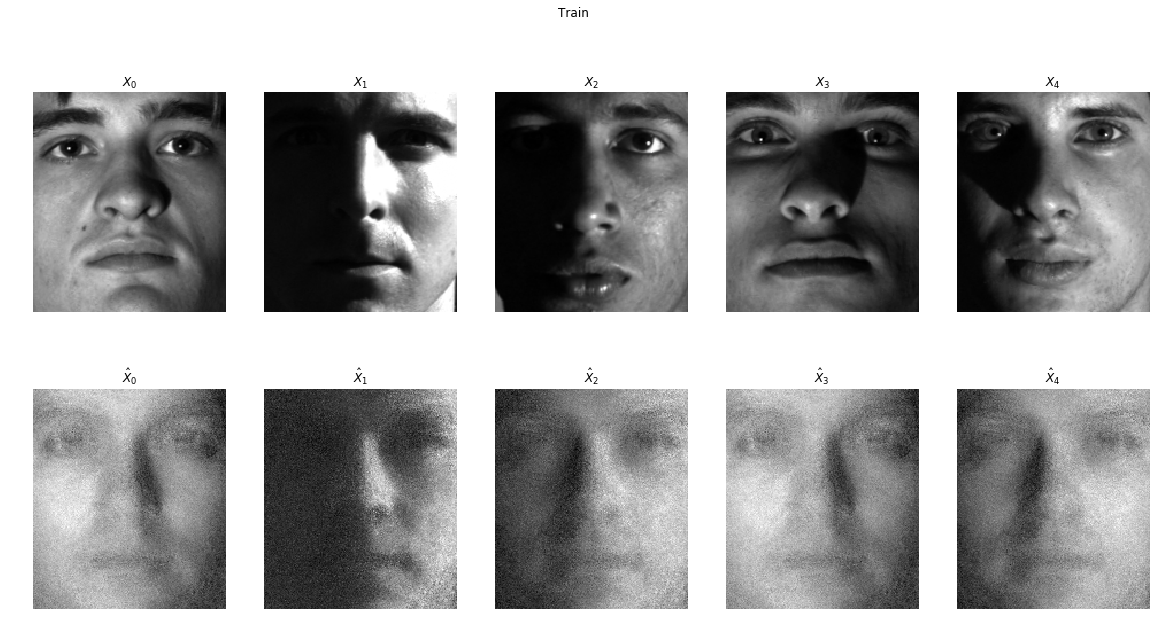

In [18]:
xhat = oe.decode(zhat_train)

fig, ax = plt.subplots(figsize = (20,10), nrows=2, ncols=5)
fig.suptitle('Train')
for i in range(len(ax)):
    row = ax[i]
    for j in range(len(row)):
        subplt = row[j]
        if i == 0:
            subplt.set_title("$X_%d$" %(j))
            subplt.imshow(X_train[j].reshape((shapeX[1],shapeX[2])), plt.cm.gray)
        if i == 1:
            subplt.set_title("$\hat{X}_%d$" %(j))
            subplt.imshow(xhat[j].reshape((shapeX[1],shapeX[2])), plt.cm.gray)
        
        subplt.axis('off')
        
fig.subplots_adjust(wspace=None, hspace=None)
plt.show()

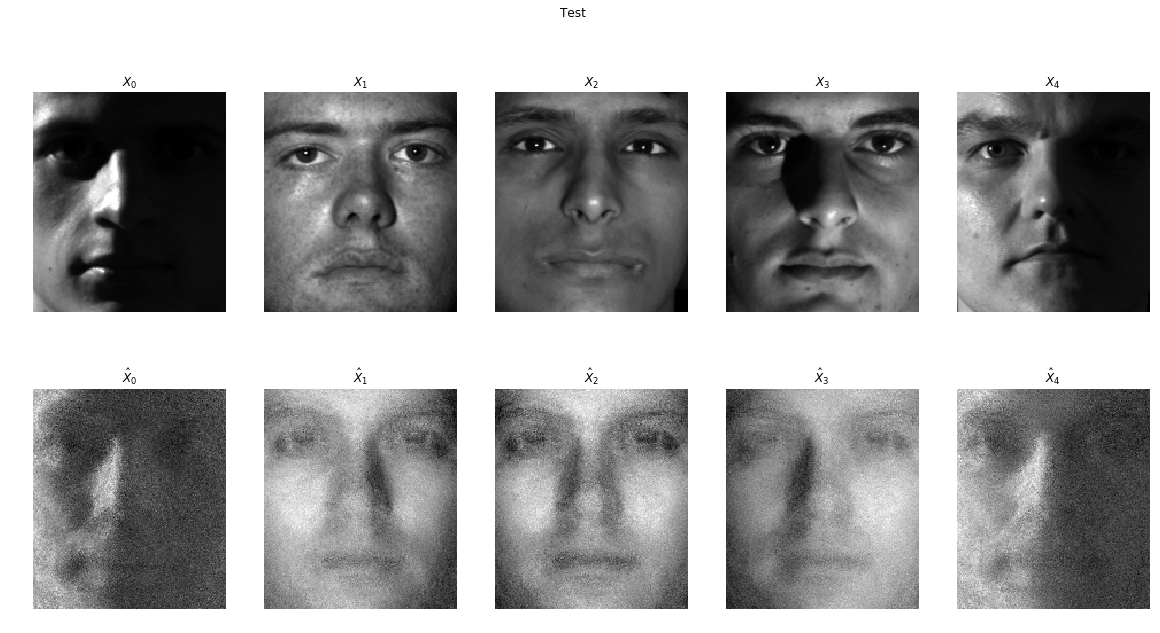

In [19]:
xhat = oe.decode(zhat_test)

fig, ax = plt.subplots(figsize = (20,10), nrows=2, ncols=5)
fig.suptitle('Test')
for i in range(len(ax)):
    row = ax[i]
    for j in range(len(row)):
        subplt = row[j]
        if i == 0:
            subplt.set_title("$X_%d$" %(j))
            subplt.imshow(X_test[j].reshape((shapeX[1],shapeX[2])), plt.cm.gray)
        if i == 1:
            subplt.set_title("$\hat{X}_%d$" %(j))
            subplt.imshow(xhat[j].reshape((shapeX[1],shapeX[2])), plt.cm.gray)
        
        subplt.axis('off')
        
fig.subplots_adjust(wspace=None, hspace=None)
plt.show()

# SubOptimal Encoding

## Autoencoding

In [20]:
n_in = X.shape[-1]
k = 2
n_out = X.shape[-1]

widths = [300, 300]

In [21]:
encoder = MLP(n_in, k, widths)
decoder = MLP(k, n_out, widths)

In [22]:
oe = OptimalEncoding(encoder, decoder, k)

100%|██████████| 100/100 [00:07<00:00, 12.77it/s]


Sigma: 0.100000
Final task loss: -43926.510417


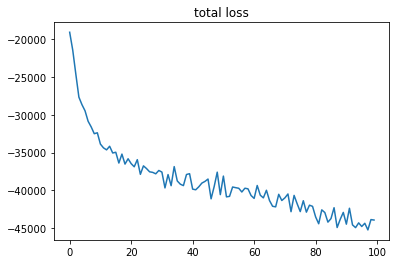

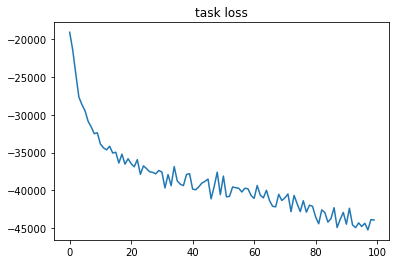

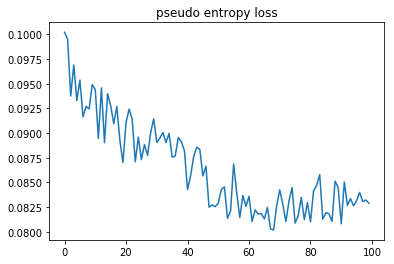

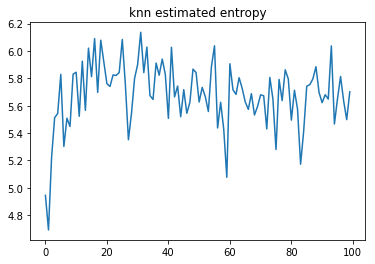

In [23]:
oe.train(X_train, y=None, 
         min_entropy=False, sigma = sigma, task = 'autoencoder', 
         heteroskedastic = True, n_samples = 5,
         epochs=100, batch_size=64, lr=1e-3)

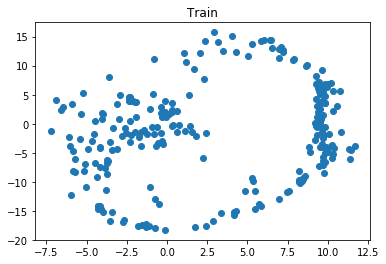

In [24]:
zhat_train = oe.encode(X_train, sigma=sigma)
plt.scatter(zhat_train[:,0], zhat_train[:,1])
plt.title('Train')

In [25]:
entropy(zhat_train)

5.4760322425023817

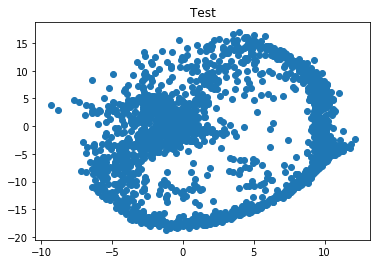

In [26]:
zhat_test = oe.encode(X_test, sigma=0)
plt.scatter(zhat_test[:,0], zhat_test[:,1])
plt.title('Test')

In [27]:
entropy(zhat_test)

5.3038376757009189

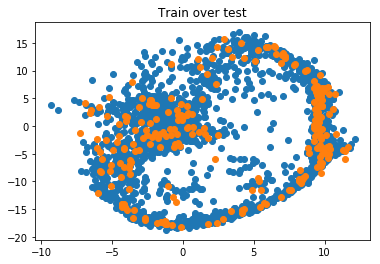

In [28]:
plt.scatter(zhat_test[:,0], zhat_test[:,1])
plt.scatter(zhat_train[:,0], zhat_train[:,1])
plt.title('Train over test')

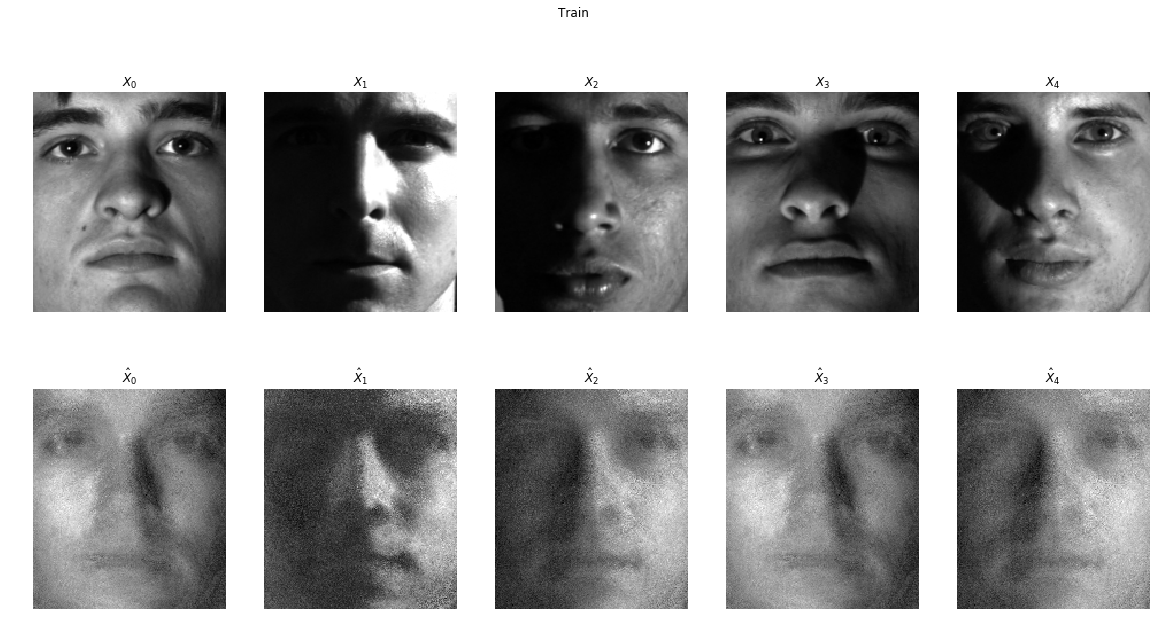

In [29]:
xhat = oe.decode(zhat_train)

fig, ax = plt.subplots(figsize = (20,10), nrows=2, ncols=5)
fig.suptitle('Train')
for i in range(len(ax)):
    row = ax[i]
    for j in range(len(row)):
        subplt = row[j]
        if i == 0:
            subplt.set_title("$X_%d$" %(j))
            subplt.imshow(X_train[j].reshape((shapeX[1],shapeX[2])), plt.cm.gray)
        if i == 1:
            subplt.set_title("$\hat{X}_%d$" %(j))
            subplt.imshow(xhat[j].reshape((shapeX[1],shapeX[2])), plt.cm.gray)
        
        subplt.axis('off')
        
fig.subplots_adjust(wspace=None, hspace=None)
plt.show()

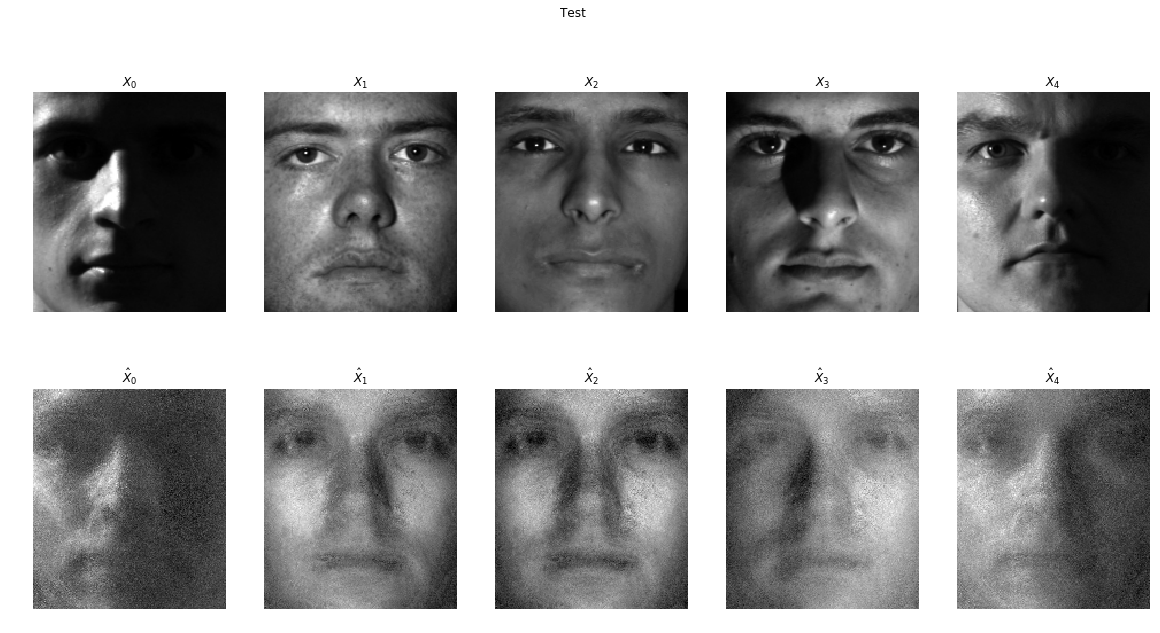

In [30]:
xhat = oe.decode(zhat_test)

fig, ax = plt.subplots(figsize = (20,10), nrows=2, ncols=5)
fig.suptitle('Test')
for i in range(len(ax)):
    row = ax[i]
    for j in range(len(row)):
        subplt = row[j]
        if i == 0:
            subplt.set_title("$X_%d$" %(j))
            subplt.imshow(X_test[j].reshape((shapeX[1],shapeX[2])), plt.cm.gray)
        if i == 1:
            subplt.set_title("$\hat{X}_%d$" %(j))
            subplt.imshow(xhat[j].reshape((shapeX[1],shapeX[2])), plt.cm.gray)
        
        subplt.axis('off')
        
fig.subplots_adjust(wspace=None, hspace=None)
plt.show()